In [19]:
import argparse
import os
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
from torch import optim
from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
from models import FEDformer, Autoformer, Informer, Transformer
from utils.tools import EarlyStopping, adjust_learning_rate, visual
from utils.metrics import metric


In [2]:
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')
# basic config
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--task_id', type=str, default='test', help='task id')
parser.add_argument('--model', type=str, default='FEDformer',
                    help='model name, options: [FEDformer, Autoformer, Informer, Transformer]')
# supplementary config for FEDformer model
parser.add_argument('--version', type=str, default='Fourier',
                    help='for FEDformer, there are two versions to choose, options: [Fourier, Wavelets]')
parser.add_argument('--mode_select', type=str, default='random',
                    help='for FEDformer, there are two mode selection method, options: [random, low]')
parser.add_argument('--modes', type=int, default=64, help='modes to be selected random 64')
parser.add_argument('--L', type=int, default=3, help='ignore level')
parser.add_argument('--base', type=str, default='legendre', help='mwt base')
parser.add_argument('--cross_activation', type=str, default='tanh',
                    help='mwt cross atention activation function tanh or softmax')
# data loader
parser.add_argument('--data', type=str, default='ETTh1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./dataset/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, '
                         'S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
# parser.add_argument('--freq', type=str, default='h',
#                     help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, '
#                          'b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')

parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')
# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
# parser.add_argument('--cross_activation', type=str, default='tanh'
# model define
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', default=[24], help='window size of moving average')
# parser.add_argument('--factor', type=int, default=1, help='attn factor')

parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')
# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=3, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1', help='device ids of multi gpus')
args, unknown = parser.parse_known_args()
args.freq = 'h'
args.factor = 1
# mps is not working
# args.use_gpu = True if torch.backends.mps.is_built() and args.use_gpu else False
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
# overwrite args
# args.root_path = './dataset/ETT-small/'
# args.data_path = 'ETTh1.csv'
# args.task_id = 'ETTh1'
# args.data = 'ETTh1'
args.root_path = './dataset/crypto/'
args.data_path = 'BTCUSDT_60min.csv'
args.task_id = 'BTCUSDT_60min'
args.data = 'cryptoh1'
args.features = 'M'
args.seq_len = 96
args.label_len = 48
args.pred_len = 12
args.e_layers = 2
args.d_layers = 1
args.factor = 3
# args.enc_in = 7
# args.dec_in = 7
# args.c_out = 7
args.enc_in = 10
args.dec_in = 10
args.c_out = 10
args.des = 'Exp'
args.d_model = 512
args.itr = 3
args.train_stride = 6
print('Args in experiment:')
print(args)

Args in experiment:
Namespace(is_training=1, task_id='BTCUSDT_60min', model='FEDformer', version='Fourier', mode_select='random', modes=64, L=3, base='legendre', cross_activation='tanh', data='cryptoh1', root_path='./dataset/crypto/', data_path='BTCUSDT_60min.csv', features='M', target='OT', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=12, enc_in=10, dec_in=10, c_out=10, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=[24], distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=3, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', loss='mse', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1', freq='h', factor=3, train_stride=6)


In [3]:
test_data, test_loader = data_provider(args, flag='test')

test 5126


In [4]:
test_data.scaler

StandardScaler()

In [5]:
model_dict = {
    'FEDformer': FEDformer,
    'Autoformer': Autoformer,
    'Transformer': Transformer,
    'Informer': Informer,
}
model = model_dict[args.model].Model(args).float()

fourier enhanced block used!
modes=64, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
fourier enhanced block used!
modes=64, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
 fourier enhanced cross attention used!
modes_q=30, index_q=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
modes_kv=48, index_kv=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
enc_modes: 48, dec_modes: 30


In [6]:
ii = 0
setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(args.task_id,
                                                                                                      args.model,
                                                                                                      args.data,
                                                                                                      args.features,
                                                                                                      args.seq_len,
                                                                                                      args.label_len,
                                                                                                      args.pred_len,
                                                                                                      args.d_model,
                                                                                                      args.n_heads,
                                                                                                      args.e_layers,
                                                                                                      args.d_layers,
                                                                                                      args.d_ff,
                                                                                                      args.factor,
                                                                                                      args.embed,
                                                                                                      args.distil,
                                                                                                      args.des, ii)

In [7]:
# overwrite setting
setting = 'BTCUSDT_60min_FEDformer_random_modes64_cryptoh1_ftM_sl96_ll48_pl12_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0'

In [8]:
model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))
model.to('cuda')

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(10, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(10, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
 

In [9]:
 device = torch.device('cuda:{}'.format(args.gpu))

In [10]:
preds = []
trues = []
folder_path = './test_results/' + setting + '/'
if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            
with torch.no_grad():
           for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
               batch_x = batch_x.float().to(device)
               batch_y = batch_y.float().to(device)
               batch_x_mark = batch_x_mark.float().to(device)
               batch_y_mark = batch_y_mark.float().to(device)
               # decoder input
               dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
               dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
               # encoder - decoder
               if args.use_amp:
                   with torch.cuda.amp.autocast():
                       if args.output_attention:
                           outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                       else:
                           outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
               else:
                   if args.output_attention:
                       outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                   else:
                       outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
               f_dim = -1 if args.features == 'MS' else 0
               batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
               outputs = outputs.detach().cpu().numpy()
               batch_y = batch_y.detach().cpu().numpy()
               pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
               true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()
               preds.append(pred)
               trues.append(true)
               if i % 20 == 0:
                   input = batch_x.detach().cpu().numpy()
                   gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                   pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                   visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

preds = np.array(preds)
trues = np.array(trues)
print('test shape:', preds.shape, trues.shape)
preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
print('test shape:', preds.shape, trues.shape)
mae, mse, rmse, mape, mspe = metric(preds, trues)
print('mse:{}, mae:{}'.format(mse, mae))

test shape: (160, 32, 12, 10) (160, 32, 12, 10)
test shape: (5120, 12, 10) (5120, 12, 10)
mse:0.9020483493804932, mae:0.280515193939209


In [11]:
preds.shape

(5120, 12, 10)

In [12]:
trues.shape

(5120, 12, 10)

In [14]:
trues[0].shape

(12, 10)

In [16]:
test_data.scaler.inverse_transform(preds[0])

array([[20923.312   , 20330.367   , 20334.914   , 21067.44    ,
         5004.817   , 20564.934   , 19679.336   , 20592.336   ,
        20434.07    ,    64.48469 ],
       [22098.916   , 21747.676   , 21110.348   , 20264.09    ,
         4504.6196  , 20700.498   , 20161.262   , 20817.018   ,
        20561.465   ,    63.19633 ],
       [21363.994   , 22502.033   , 20506.35    , 22052.28    ,
         4329.0547  , 20719.047   , 20747.316   , 20391.252   ,
        20532.223   ,    63.003475],
       [20636.416   , 22358.65    , 20889.379   , 21399.326   ,
         3978.842   , 20603.04    , 20991.395   , 21474.588   ,
        20389.24    ,    61.31579 ],
       [21451.38    , 22729.557   , 20661.596   , 20570.385   ,
         3990.6987  , 21104.473   , 20849.562   , 21416.662   ,
        20971.57    ,    62.212597],
       [22377.002   , 22527.646   , 21185.13    , 21584.783   ,
         4070.8237  , 21317.855   , 22037.5     , 22188.564   ,
        21239.135   ,    60.37657 ],
       [22

In [34]:
close_pred = preds[:, :, 3]
close_true = trues[:, :, 3]
mae, mse, rmse, mape, mspe = metric(preds, trues)
print('mse:{}, mae:{}'.format(mse, mae))


mse:0.9020483493804932, mae:0.280515193939209


In [17]:
test_data.scaler.inverse_transform(trues[0])

array([[20416.45    , 20552.29    , 20269.95    , 20300.69    ,
         3668.9224  , 20217.105   , 20012.662   , 19695.357   ,
        19556.852   ,    66.16684 ],
       [20300.68    , 20309.55    , 19688.      , 19730.76    ,
         6570.887   , 19973.932   , 19918.695   , 19701.795   ,
        19573.416   ,    52.666214],
       [19730.77    , 19773.71    , 19366.89    , 19409.23    ,
         7334.118   , 19691.582   , 19748.873   , 19648.602   ,
        19557.777   ,    46.857533],
       [19409.23    , 19579.43    , 19315.91    , 19465.37    ,
         4453.066   , 19578.477   , 19654.373   , 19615.287   ,
        19548.977   ,    47.937244],
       [19465.37    , 19492.      , 19361.55    , 19401.67    ,
         3292.1504  , 19490.072   , 19570.139   , 19576.447   ,
        19534.95    ,    46.775955],
       [19401.66    , 19669.42    , 19337.      , 19579.11    ,
         4650.6934  , 19534.592   , 19573.129   , 19576.932   ,
        19539.154   ,    50.381786],
       [19

In [32]:
def plot_n_examples(n: int, y_pred: np.ndarray, y_actuals: np.ndarray, y_baseline_actuals: np.ndarray=None):
    
    random_indices = np.random.randint(0, y_pred.shape[0], n)
    fig, axes = plt.subplots(n, 1, figsize=(10, 10))
    
    for i, index in enumerate(random_indices):
        pred = test_data.scaler.inverse_transform(y_pred[index])
        actual = test_data.scaler.inverse_transform(y_actuals[index])
        axes[i].plot(pred[:,3], label='pred')
        axes[i].plot(actual[:,3], label='actual')
        if y_baseline_actuals is not None:
            axes[i].plot(y_baseline_actuals[index, :], label='baseline')
        axes[i].legend()
    
    plt.show()

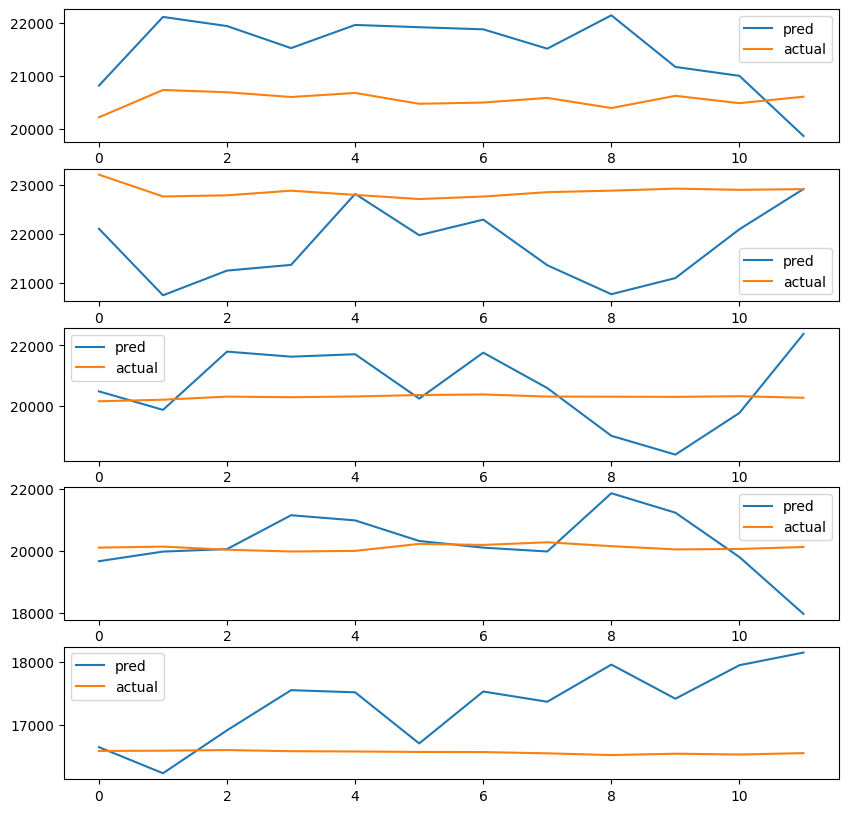

In [33]:
%matplotlib inline
plot_n_examples(5, preds, trues)